In [9]:
# Standard python libraries
import os
import time
import datetime
import requests
import logging.config

# Installed libraries
from matplotlib import pyplot as plt
from typing import Tuple
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as SparkTypes, Window
from tqdm import tqdm

from lightautoml.spark.automl.presets.tabular_presets import SparkTabularAutoML
from lightautoml.spark.dataset.base import SparkDataFrame, SparkDataset
from lightautoml.spark.tasks.base import SparkTask

In [10]:
DATASET_DIR = '/tmp/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

In [11]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)
        
data = pd.read_csv(DATASET_FULLNAME)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data.to_csv("/tmp/sampled_app_train.csv", index=False)

CPU times: user 544 ms, sys: 27.9 ms, total: 572 ms
Wall time: 571 ms


In [12]:
def prepare_test_and_train(spark: SparkSession, path:str, seed: int) -> Tuple[SparkDataFrame, SparkDataFrame]:
    data = spark.read.csv(path, header=True, escape="\"")

    data = data.select(
        '*',
        F.monotonically_increasing_id().alias(SparkDataset.ID_COLUMN),
        F.rand(seed).alias('is_test')
    ).cache()
    data.write.mode('overwrite').format('noop').save()

    train_data = data.where(F.col('is_test') < 0.8).drop('is_test').cache()
    test_data = data.where(F.col('is_test') >= 0.8).drop('is_test').cache()

    train_data.write.mode('overwrite').format('noop').save()
    test_data.write.mode('overwrite').format('noop').save()

    return train_data, test_data

In [13]:
def get_spark_session():
    if os.environ.get("SCRIPT_ENV", None) == "cluster":
        return SparkSession.builder.getOrCreate()

    spark_sess = (
        SparkSession
        .builder
        .master("local[*]")
        .config("spark.jars", "../../jars/spark-lightautoml_2.12-0.1.jar")
        .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5")
        .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
        .config("spark.sql.shuffle.partitions", "16")
        .config("spark.driver.memory", "12g")
        .config("spark.executor.memory", "12g")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .getOrCreate()
    )

    return spark_sess

In [14]:
spark = get_spark_session()

22/03/17 14:11:24 WARN Utils: Your hostname, desktop resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface wlp7s0)
22/03/17 14:11:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/azamat/.ivy2/cache
The jars for the packages stored in: /home/azamat/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-89bca08f-ada8-4300-8c1c-a2f5f21356e8;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/azamat/projects/LightAutoML/.venv/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;0.9.5 in central
	found com.microsoft.azure#synapseml-core_2.12;0.9.5 in central
	found org.scalactic#scalactic_2.12;3.0.5 in central
	found org.scala-lang#scala-reflect;2.12.4 in central
	found io.spray#spray-json_2.12;1.3.2 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents#httpclient;4.5.6 in central
	found org.apache.httpcomponents#httpcore;4.4.10 in central
	found commons-logging#commons-logging;1.2 in central
	found commons-codec#commons-codec;1.10 in central
	found org.apache.httpcomponents#httpmime;4.5.6 in central
	found com.linkedin.isolation-forest#isolation-forest_3.2.0_2.12;2.0.8 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found org.typelevel#macro-compat_2.12;1.1.1 in central
	found org.apache.spark#spark-avro_2.12;3.2.0 in central
	found org.tukaani#xz;1.8 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.testng#testng;6.8.8 in central
	found org.bean

22/03/17 14:11:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [15]:
seed = 42
cv = 2
# use_algos = [["lgb", "linear_l2"], ["lgb"]]
use_algos = [["lgb"]]
task_type = "binary"
roles = {"target": "TARGET", "drop": ["SK_ID_CURR"]}

In [16]:
train_data, test_data = prepare_test_and_train(spark, "/tmp/sampled_app_train.csv", seed)

22/03/17 14:11:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [17]:
task = SparkTask(task_type)

automl = SparkTabularAutoML(
    spark=spark,
    task=task,
    lgb_params={'use_single_dataset_mode': True},
    linear_l2_params={"default_params": {"regParam": [1]}},
    general_params={"use_algos": use_algos},
    reader_params={"cv": cv, "advanced_roles": False, 'random_state': seed}
)

oof_pred = automl.fit_predict(
    train_data,
    roles=roles
)

features pipeline ctr
lama advanced pipeline ctr
features pipeline ctr
i am here


22/03/17 14:11:41 WARN CacheManager: Asked to cache already cached data.


[LightGBM] [Info] Number of positive: 332, number of negative: 3689
[LightGBM] [Warning] Only find one worker, will switch to serial tree learner
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,015178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10023
[LightGBM] [Info] Number of data points in the train set: 4021, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,082567 -> initscore=-2,407976
[LightGBM] [Info] Start training from score -2,407976


22/03/17 14:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1742.6 KiB


[LightGBM] [Info] Number of positive: 332, number of negative: 3689
[LightGBM] [Warning] Only find one worker, will switch to serial tree learner
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,010735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10398
[LightGBM] [Info] Number of data points in the train set: 4021, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,082567 -> initscore=-2,407976
[LightGBM] [Info] Start training from score -2,407976


[LightGBM] [Info] Number of positive: 313, number of negative: 3744
[LightGBM] [Warning] Only find one worker, will switch to serial tree learner
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0,009160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10362
[LightGBM] [Info] Number of data points in the train set: 4057, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,077151 -> initscore=-2,481707
[LightGBM] [Info] Start training from score -2,481707


22/03/17 14:13:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:13:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:13:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


In [18]:
%%time

grid, ys, counts = automl.get_individual_pdp(test_data, feature_name='DAYS_BIRTH', n_bins=30)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:39<00:00,  5.32s/it]

CPU times: user 15.2 s, sys: 5.32 s, total: 20.6 s
Wall time: 2min 40s


/home/azamat/projects/LightAutoML/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


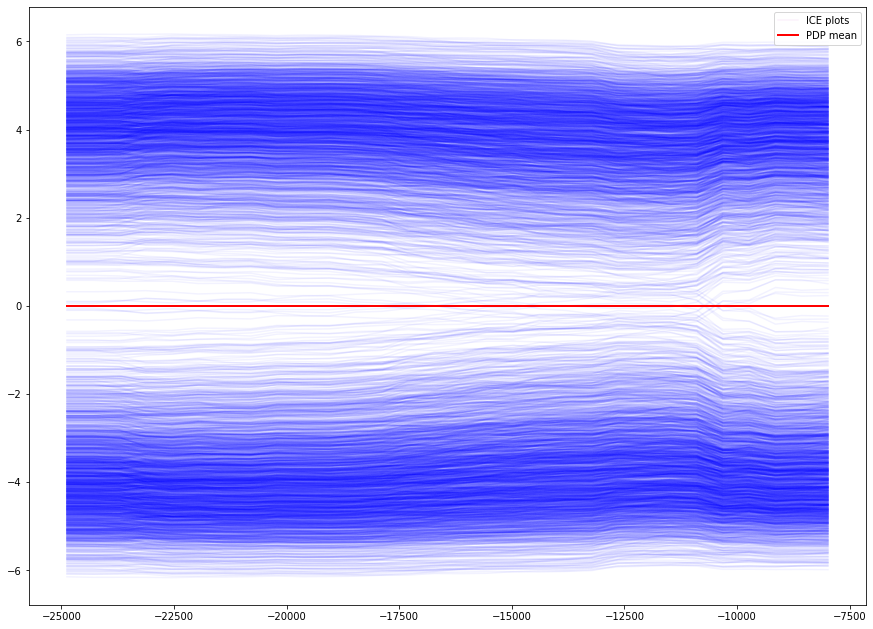

CPU times: user 16.2 s, sys: 2.11 s, total: 18.3 s
Wall time: 14.5 s


In [19]:
%%time

X = np.array([item.ravel() for item in ys]).T

plt.figure(figsize=(15, 11))
plt.plot(grid, X[0], alpha=0.05, color='m', label='ICE plots')
for i in range(1, X.shape[0]):
    plt.plot(grid, X[i], alpha=0.05, color='b')
plt.plot(grid, X.mean(axis=0), linewidth=2, color='r', label='PDP mean')
plt.legend()
plt.show()

### Built-in function:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:34<00:00,  5.15s/it]


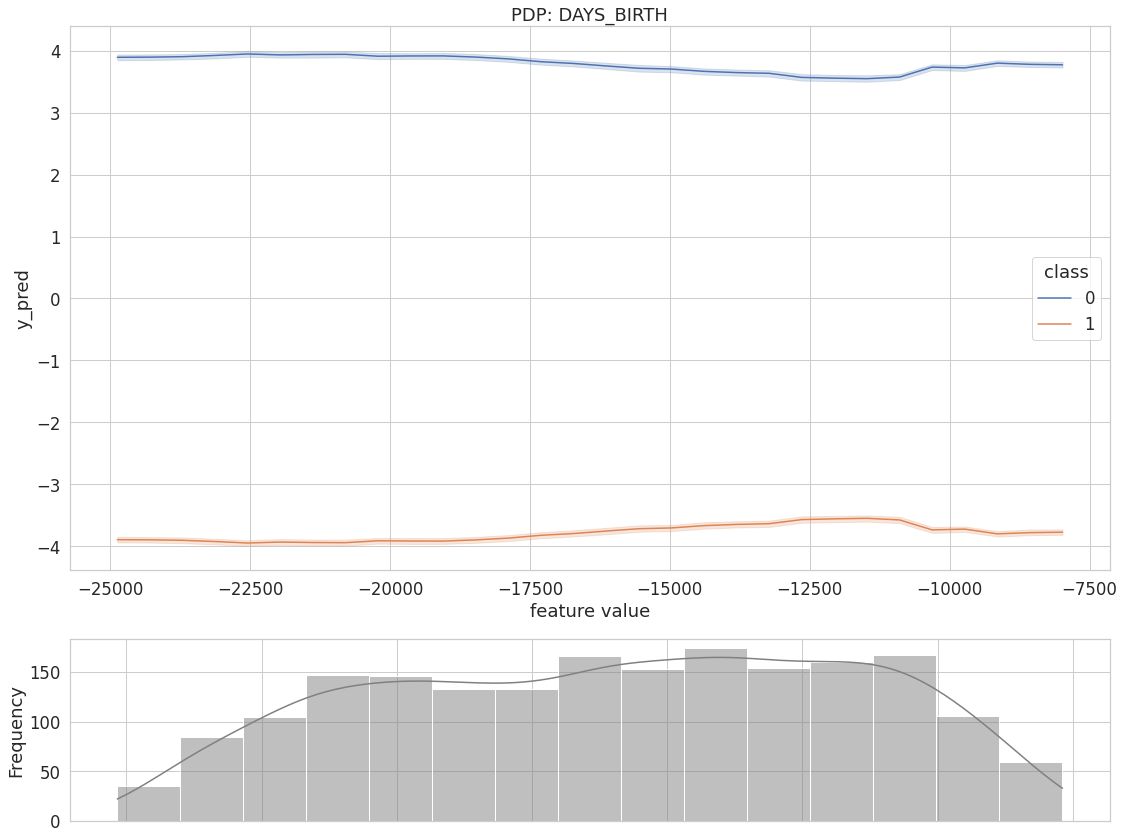

In [20]:
automl.plot_pdp(test_data, feature_name='DAYS_BIRTH', n_bins=30)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:33<00:00,  5.13s/it]


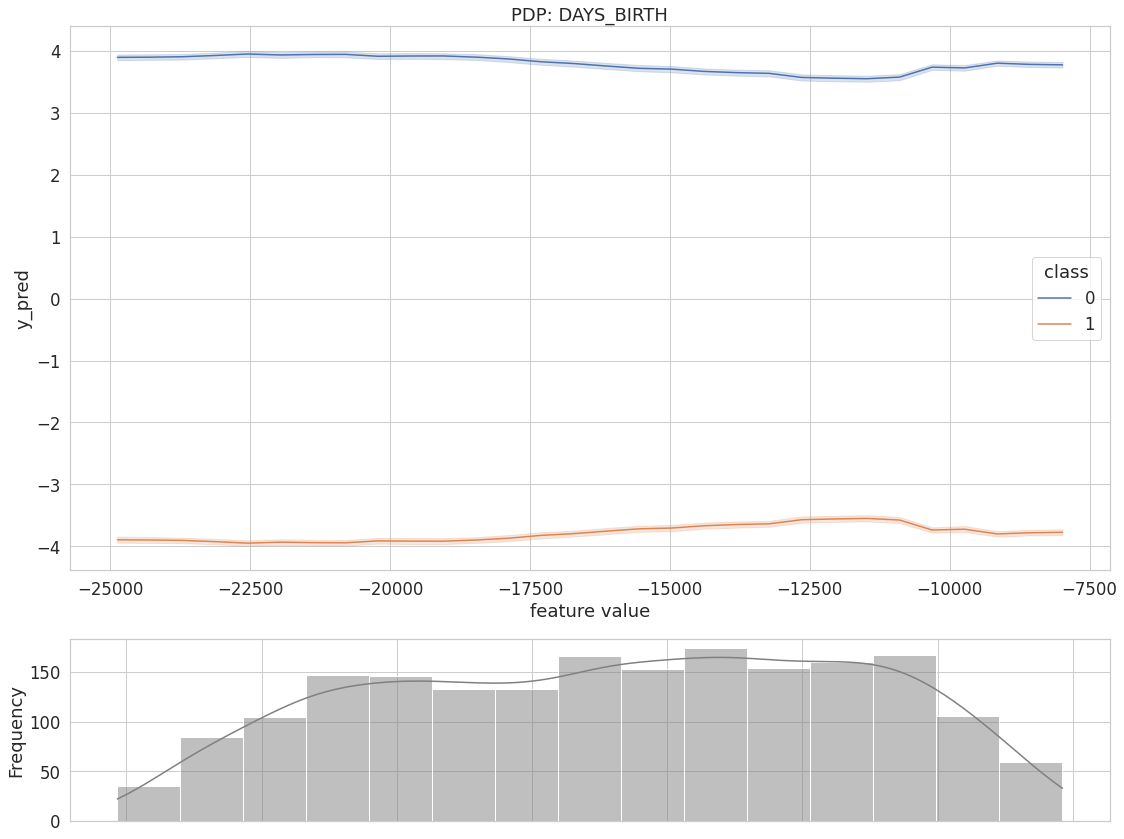

In [21]:
automl.plot_pdp(test_data, feature_name='DAYS_BIRTH', individual=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.11s/it]
22/03/17 14:22:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/17 14:22:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/17 14:22:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/17 14:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/17 14:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/03/17 14:22:46 WARN Win

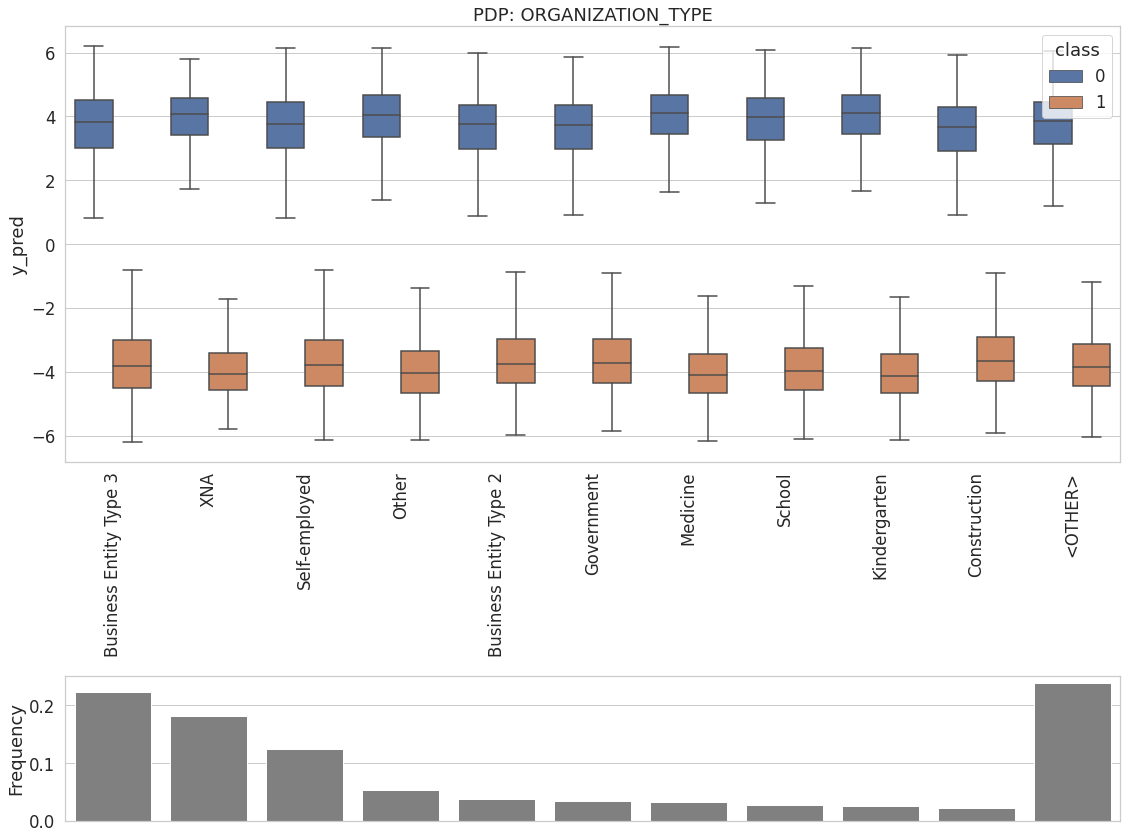

CPU times: user 6.74 s, sys: 2.33 s, total: 9.07 s
Wall time: 58.9 s


In [22]:
%%time

automl.plot_pdp(test_data, feature_name='ORGANIZATION_TYPE')

 83%|████████████████████████████████████████████████████████████████████████████████████████████                   | 34/41 [02:50<00:34,  4.87s/it]22/03/17 14:25:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [03:25<00:00,  5.00s/it]


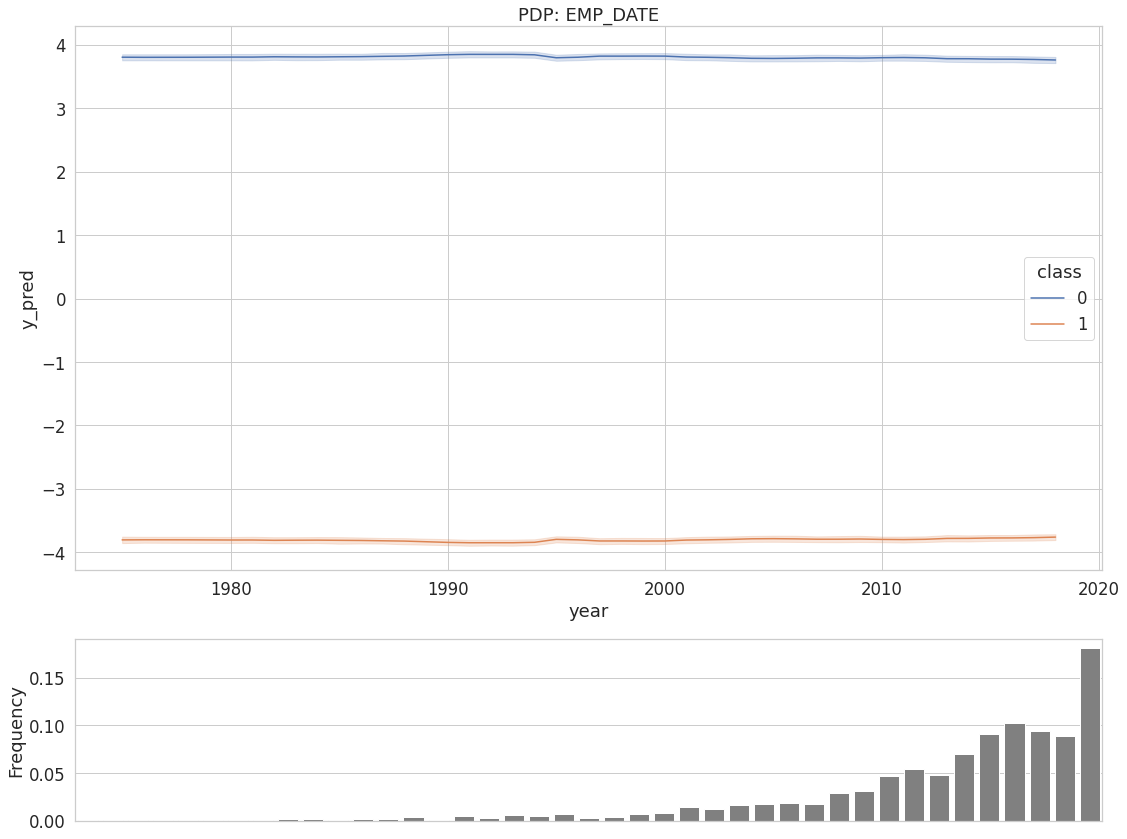

CPU times: user 24.1 s, sys: 6.75 s, total: 30.8 s
Wall time: 3min 30s


In [23]:
%%time

automl.plot_pdp(test_data, feature_name='EMP_DATE', datetime_level='year')

In [24]:
automl.get_feature_scores(data=test_data)

,Feature,Importance
0,EXT_SOURCE_3,8243.475307
1,EXT_SOURCE_2,6577.889728
2,DAYS_BIRTH,4149.948383
3,DAYS_REGISTRATION,3619.614171
4,DAYS_ID_PUBLISH,3530.482861
...,...,...
100,FLAG_CONT_MOBILE,20.045500
101,FLAG_DOCUMENT_16,18.349880
102,NONLIVINGAPARTMENTS_MODE,18.089360
103,ELEVATORS_MEDI,10.736680


In [25]:
automl.get_feature_scores(calc_method="accurate", data=test_data, silent=False)

22/03/17 14:26:24 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:26:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:26:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:26:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:26:46 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:26:51 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:26:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:27:01 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:27:06 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:27:11 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:27:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:27:21 WARN DAGScheduler: Broadcasting larg

22/03/17 14:34:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:34:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:34:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:34:50 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:34:55 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:35:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:35:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:35:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:35:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:35:20 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/03/17 14:35:25 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


,Feature,Importance
0,EXT_SOURCE_3,0.055738
1,EXT_SOURCE_2,0.032519
2,WALLSMATERIAL_MODE,0.023120
3,OCCUPATION_TYPE,0.020402
4,EXT_SOURCE_1,0.015352
...,...,...
100,CNT_CHILDREN,-0.001260
101,LIVINGAPARTMENTS_AVG,-0.001436
102,EMP_DATE,-0.001932
103,HOUR_APPR_PROCESS_START,-0.002152
